In [46]:
# Step: Load Required Libraries
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [47]:
# Step: Load the Trained Model
model = tf.keras.models.load_model('../models/kline_model.keras')

# Load the scalers
scaler_features = joblib.load('../models/kline_model_scaler_features.pkl')
scaler_target = joblib.load('../models/kline_model_scaler_target.pkl')

print('Successfully loaded!')

Successfully loaded!


In [48]:
# Step: Load and Preprocess Kline Features
# Load the features
kline_df = pd.read_csv('../features/kline/1m/features.csv')

# Assuming the data has been loaded and processed into 'kline_df'
# Extract features and target
features = kline_df[['openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover',
                     'priceChange', 'logReturn', 'SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 
                     'hourOfDay', 'dayOfWeek', 'weekOfYear', 'monthOfYear', 'minuteOfHour', 
                     'isWeekend', 'highLowRange', 'stdReturn_5m', 'stdReturn_10m', 
                     'RSI_14', 'MACD_line', 'MACD_signal', 'MACD_histogram', 
                     'Stochastic_K', 'Stochastic_D', 'ROC_14']]

target = kline_df['closePrice'].shift(-1)  # Shift by 1 to predict the next closePrice
target = target.dropna()  # Drop last row because it has NaN value after shift
features = features.iloc[:-1]  # Drop the last row from features to match target size

# Scale the features
features_scaled = scaler_features.fit_transform(features)

# Scale the target (closePrice)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [49]:
# Step: Make Predictions
y_pred_scaled = model.predict(features_scaled)
y_pred = scaler_target.inverse_transform(y_pred_scaled)

315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [50]:
# Step: Model Evaluation
mse = mean_squared_error(target, y_pred)
mae = mean_absolute_error(target, y_pred)

print(f'Model Evaluation Metrics:')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Model Evaluation Metrics:
Mean Squared Error (MSE): 2684.5437325212774
Mean Absolute Error (MAE): 34.52187360269262


In [62]:
# Step: Calculate diff sign error

# 1) Calculate the difference between adjacent actual and predicted close prices
actual_diff = np.diff(target)  # Difference between adjacent actual close prices
predicted_diff = np.diff(y_pred.flatten())  # Difference between adjacent predicted close prices

# 2) Calculate the sign of the actual and predicted differences
actual_sign = np.sign(actual_diff)
predicted_sign = np.sign(predicted_diff)

# 4) Compare the signs and count how many times they are the same
same_sign_count = np.sum(actual_sign == predicted_sign)

# Print the results
print(f"Number of times the signs are the same: {same_sign_count} of {len(actual_sign)}")

Number of times the signs are the same: 5058 of 10063


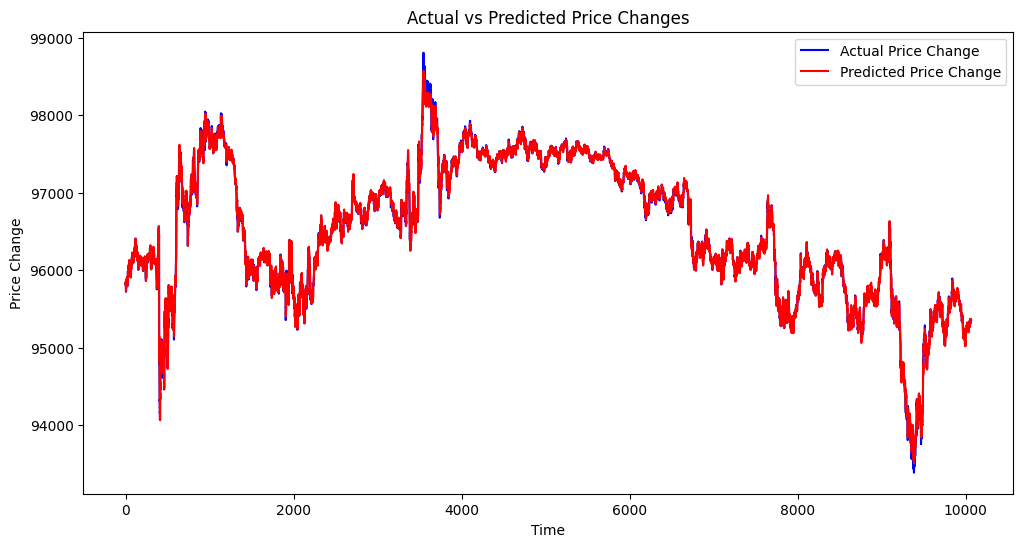

In [51]:
# Step: Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(target.values, label='Actual Price Change', color='blue')
plt.plot(y_pred, label='Predicted Price Change', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price Change')
plt.title('Actual vs Predicted Price Changes')
plt.show()

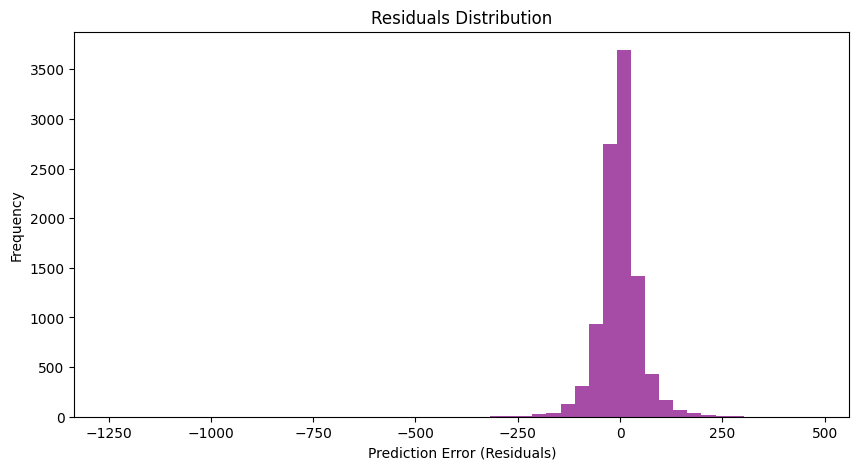

In [52]:
# Step: Error Analysis (Residual Plot)
residuals = target.values - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.xlabel('Prediction Error (Residuals)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()